In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import series_to_supervised
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model, Model
from preprocess import water_postprocess
from performance import metrics_s1_t1

### Water Level

In [104]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.7
split_2 = 0.85

In [105]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = water_postprocess(n_hours, k, masked_value, split_1, split_2)


train_X_mask_rain_acc = train_X_mask[:, 0, 0]
val_X_mask_rain_acc = val_X_mask[:, 0, 0]
test_X_mask_rain_acc = test_X_mask[:, 0, 0]


percentile = 95
merged_array = np.concatenate((train_X_mask_rain_acc, val_X_mask_rain_acc, test_X_mask_rain_acc))
percentile_rain = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_rain)


train_X_mask_extreme = train_X_mask[train_X_mask_rain_acc > percentile_rain]
train_ws_y_extreme = train_ws_y[train_X_mask_rain_acc > percentile_rain]
train_X_mask_normal = train_X_mask[train_X_mask_rain_acc <= percentile_rain]
train_ws_y_normal = train_ws_y[train_X_mask_rain_acc <= percentile_rain]

Index(['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2',
       'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26', 'HWS_S25A',
       'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'],
      dtype='object')
95th Percentile of Daily Rain: 0.010711610503493287


In [106]:
# Number of samples you want to randomly pick
sample_size = 50

# Randomly select indices without replacement
norm_indices = np.random.choice(train_X_mask_normal.shape[0], sample_size, replace=False)
extre_indices = np.random.choice(train_X_mask_extreme.shape[0], sample_size, replace=False)


# Use the selected indices to get the random subset
norm_subset = train_X_mask_normal[norm_indices]
extre_subset = train_X_mask_extreme[extre_indices]

In [126]:
layer_index = -2

# saved_model = load_model('../saved_models_mlp/water_all_95.h5')
# saved_model = load_model('../saved_models_mlp/water_all_weighted_META_95.h5')
saved_model = load_model('../saved_models_mlp/water_all_weighted_META_95_ft.h5')

embedding_model = Model(inputs=saved_model.input, outputs=saved_model.layers[layer_index].output)

normal_embed = embedding_model.predict(norm_subset)
extreme_embed = embedding_model.predict(extre_subset)

In [127]:
# Create a t-SNE model with 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)

normal_tsne = tsne.fit_transform(normal_embed)
extre_tsne = tsne.fit_transform(extreme_embed)
print(normal_tsne.shape, extre_tsne.shape)

(50, 2) (50, 2)


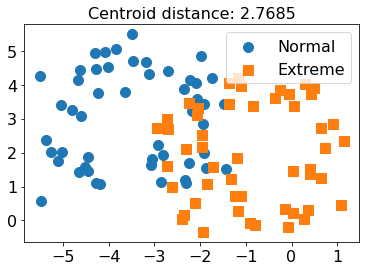

In [128]:
normal_center = np.mean(normal_tsne, axis=0)
extre_center = np.mean(extre_tsne, axis=0)
distance = np.linalg.norm(normal_center - extre_center)

plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal', marker='o', s=100)
plt.scatter(extre_tsne[:, 0], extre_tsne[:, 1], label='Extreme', marker='s', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title(f'Centroid distance: {distance:.4f}', fontsize=16)
# plt.savefig('embed_water_.jpg', bbox_inches='tight')
plt.show()

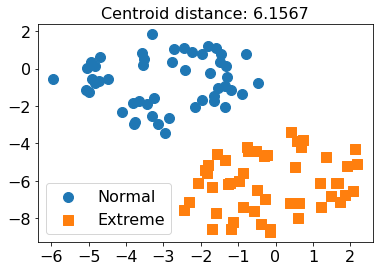

In [122]:
normal_center = np.mean(normal_tsne, axis=0)
extre_center = np.mean(extre_tsne, axis=0)
distance = np.linalg.norm(normal_center - extre_center)

plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal', marker='o', s=100)
plt.scatter(extre_tsne[:, 0], extre_tsne[:, 1], label='Extreme', marker='s', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title(f'Centroid distance: {distance:.4f}', fontsize=16)
# plt.savefig('embed_water_.jpg', bbox_inches='tight')
plt.show()

### Electricity price

In [81]:
dataset = pd.read_csv('../data/energy_weather.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
# data


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]


95th Percentile of Daily Rain: 0.7037105569454176


In [82]:
layer_index = -2

saved_model = load_model('../saved_models_mlp/price_all_weighted_META.h5')
# saved_model = load_model('../saved_models_mlp/price_all_weighted_META_ft.h5',)

embedding_model = Model(inputs=saved_model.input, outputs=saved_model.layers[layer_index].output)

normal_embed = embedding_model.predict(train_X_normal)
extreme_embed = embedding_model.predict(train_X_extreme)

In [83]:
# Number of samples you want to randomly pick
sample_size = 50

norm_indices = np.random.choice(normal_embed.shape[0], sample_size, replace=False)
extre_indices = np.random.choice(extreme_embed.shape[0], sample_size, replace=False)

norm_subset = normal_embed[norm_indices]
extre_subset = extreme_embed[extre_indices]

tsne = TSNE(n_components=2, random_state=42)

normal_tsne = tsne.fit_transform(norm_subset)
extre_tsne = tsne.fit_transform(extre_subset)
print(normal_tsne.shape, extre_tsne.shape)

(50, 2) (50, 2)


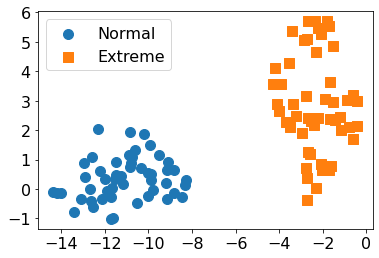

In [85]:
plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal', marker='o', s=100)
plt.scatter(extre_tsne[:, 0], extre_tsne[:, 1], label='Extreme', marker='s', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.title('PM25', fontsize=16)
plt.savefig('embed_price.jpg', bbox_inches='tight')
plt.show()

### Electricity load

In [90]:
dataset = pd.read_csv('../data/energy_weather.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
# data


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 4
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]


95th Percentile of Daily Rain: 0.793594933402977


In [91]:
layer_index = -2

saved_model = load_model('../saved_models_mlp/hydro_all_weighted_META_95.h5')
# saved_model = load_model('../saved_models_mlp/hydro_all_weighted_META_95_ft_cp.h5',)

embedding_model = Model(inputs=saved_model.input, outputs=saved_model.layers[layer_index].output)

normal_embed = embedding_model.predict(train_X_normal)
extreme_embed = embedding_model.predict(train_X_extreme)

In [92]:
sample_size = 50

norm_indices = np.random.choice(normal_embed.shape[0], sample_size, replace=False)
extre_indices = np.random.choice(extreme_embed.shape[0], sample_size, replace=False)

norm_subset = normal_embed[norm_indices]
extre_subset = extreme_embed[extre_indices]

tsne = TSNE(n_components=2, random_state=42)

normal_tsne = tsne.fit_transform(norm_subset)
extre_tsne = tsne.fit_transform(extre_subset)
print(normal_tsne.shape, extre_tsne.shape)

(50, 2) (50, 2)


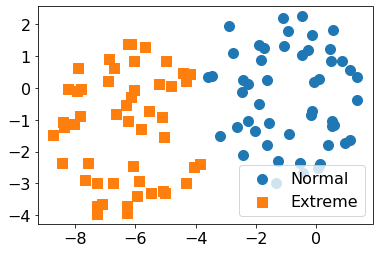

In [94]:
plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal', marker='o', s=100)
plt.scatter(extre_tsne[:, 0], extre_tsne[:, 1], label='Extreme', marker='s', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.title('PM25', fontsize=16)
plt.savefig('embed_load.jpg', bbox_inches='tight')
plt.show()

### Pressure

In [99]:
data = pd.read_csv("../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]


95th Percentile of Daily Rain: 0.48441203148316114


In [100]:
layer_index = -2

saved_model = load_model('../saved_models_mlp/pressure_all_weighted_META.h5')
# saved_model = load_model('../saved_models_mlp/pressure_all_weighted_META_ft.h5')

embedding_model = Model(inputs=saved_model.input, outputs=saved_model.layers[layer_index].output)

normal_embed = embedding_model.predict(train_X_normal)
extreme_embed = embedding_model.predict(train_X_extreme)

In [101]:
sample_size = 50

norm_indices = np.random.choice(normal_embed.shape[0], sample_size, replace=False)
extre_indices = np.random.choice(extreme_embed.shape[0], sample_size, replace=False)

norm_subset = normal_embed[norm_indices]
extre_subset = extreme_embed[extre_indices]

tsne = TSNE(n_components=2, random_state=42)

normal_tsne = tsne.fit_transform(norm_subset)
extre_tsne = tsne.fit_transform(extre_subset)
print(normal_tsne.shape, extre_tsne.shape)

(50, 2) (50, 2)


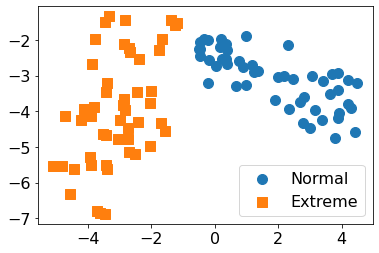

In [103]:
plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal', marker='o', s=100)
plt.scatter(extre_tsne[:, 0], extre_tsne[:, 1], label='Extreme', marker='s', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.title('PM25', fontsize=16)
plt.savefig('embed_pressure.jpg', bbox_inches='tight')
plt.show()

### PM25

In [54]:
data = pd.read_csv("../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)

values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]


95th Percentile of Daily Rain: 0.33400402414486924


In [55]:
layer_index = -2

saved_model = load_model('../saved_models_mlp/pm_all_weighted_META.h5')
# saved_model = load_model('../saved_models_mlp/pm_all_weighted_META_ft.h5')

embedding_model = Model(inputs=saved_model.input, outputs=saved_model.layers[layer_index].output)

normal_embed = embedding_model.predict(train_X_normal)
extreme_embed = embedding_model.predict(train_X_extreme)

In [56]:
sample_size = 50

norm_indices = np.random.choice(normal_embed.shape[0], sample_size, replace=False)
extre_indices = np.random.choice(extreme_embed.shape[0], sample_size, replace=False)

norm_subset = normal_embed[norm_indices]
extre_subset = extreme_embed[extre_indices]

tsne = TSNE(n_components=2, random_state=42)

normal_tsne = tsne.fit_transform(norm_subset)
extre_tsne = tsne.fit_transform(extre_subset)
print(normal_tsne.shape, extre_tsne.shape)

(50, 2) (50, 2)


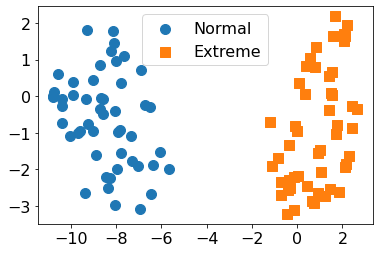

In [73]:
plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal', marker='o', s=100)
plt.scatter(extre_tsne[:, 0], extre_tsne[:, 1], label='Extreme', marker='s', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.title('PM25', fontsize=16)
plt.savefig('embed_pm.jpg', bbox_inches='tight')
plt.show()

### Hyperparameter tuning

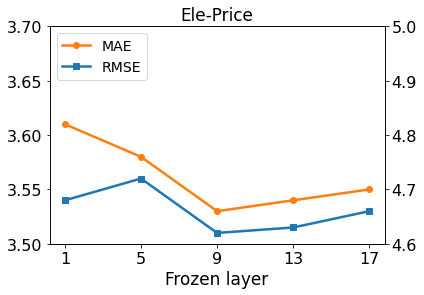

In [145]:
data = {
    # Price
    'MAE': [3.61, 3.58, 3.53, 3.54, 3.55],
    'RMSE': [4.68, 4.72, 4.62, 4.63, 4.66],
}


# Change the x_values as needed
x_values = [1, 5, 9, 13, 17]    # This is the current setting
new_x_values = [0, 1, 2, 3, 4]  # New x-values as an example

FONTSIZE=16

# Create figure and axis objects with a shared x-axis
fig, ax1 = plt.subplots()

# Price
y1_limits = (3.5, 3.7)
y2_limits = (4.6, 5.0)


ax1.set_ylim(y1_limits)
ax1.set_xlabel('Frozen layer', fontsize=FONTSIZE+1)
ax1.set_title('Ele-Price')
line1, = ax1.plot(new_x_values, data['MAE'], color='tab:orange', marker='o', linewidth=2.5, label='MAE')
ax1.tick_params(axis='y', labelsize=FONTSIZE,)

# Create y2-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylim(y2_limits)
line2, = ax2.plot(new_x_values, data['RMSE'], color='tab:blue', marker='s', linewidth=2.5, label='RMSE')  # Use new_x_values here
ax2.tick_params(axis='y', labelsize=FONTSIZE)


# Update x-ticks 
ax1.set_xticks(new_x_values)
ax1.set_xticklabels(['1', '5', '9', '13', '17'], fontsize=FONTSIZE) 


# Add legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.savefig('price_tune.jpg', bbox_inches='tight')
plt.show()

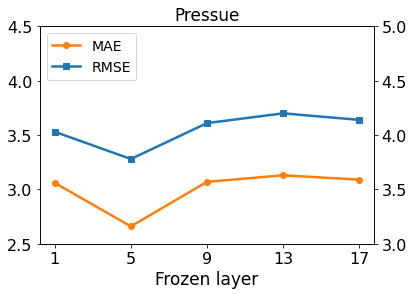

In [144]:
data = {    
    # Pressure
    'MAE': [3.06, 2.66, 3.07, 3.13, 3.09],
    'RMSE': [4.03, 3.78, 4.11, 4.20, 4.14],
}


# Change the x_values as needed
x_values = [1, 5, 9, 13, 17]    # This is the current setting
new_x_values = [0, 1, 2, 3, 4]  # New x-values as an example

FONTSIZE=16

# Create figure and axis objects with a shared x-axis
fig, ax1 = plt.subplots()

# Pressue
y1_limits = (2.5, 4.5)
y2_limits = (3.0, 5.0)


ax1.set_ylim(y1_limits)
ax1.set_xlabel('Frozen layer', fontsize=FONTSIZE+1)
ax1.set_title('Pressue')
line1, = ax1.plot(new_x_values, data['MAE'], color='tab:orange', marker='o', linewidth=2.5, label='MAE')
ax1.tick_params(axis='y', labelsize=FONTSIZE,)

# Create y2-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylim(y2_limits)
line2, = ax2.plot(new_x_values, data['RMSE'], color='tab:blue', marker='s', linewidth=2.5, label='RMSE')  # Use new_x_values here
ax2.tick_params(axis='y', labelsize=FONTSIZE)


# Update x-ticks 
ax1.set_xticks(new_x_values)
ax1.set_xticklabels(['1', '5', '9', '13', '17'], fontsize=FONTSIZE) 


# Add legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.savefig('pressure_tune.jpg', bbox_inches='tight')
plt.show()

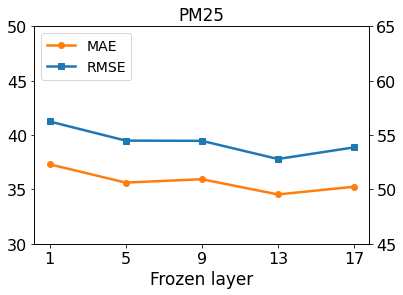

In [143]:
data = {
    # PM25
    'MAE': [37.31, 35.63, 35.94, 34.54, 35.25],
    'RMSE': [56.25, 54.49, 54.47, 52.8, 53.87],
}


# Change the x_values as needed
x_values = [1, 5, 9, 13, 17]    # This is the current setting
new_x_values = [0, 1, 2, 3, 4]  # New x-values as an example

FONTSIZE=16

# Create figure and axis objects with a shared x-axis
fig, ax1 = plt.subplots()


# Pressue
y1_limits = (30, 50)
y2_limits = (45, 65)


ax1.set_ylim(y1_limits)
ax1.set_xlabel('Frozen layer', fontsize=FONTSIZE+1)
ax1.set_title('PM25')
line1, = ax1.plot(new_x_values, data['MAE'], color='tab:orange', marker='o', linewidth=2.5, label='MAE')
ax1.tick_params(axis='y', labelsize=FONTSIZE,)

# Create y2-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylim(y2_limits)
line2, = ax2.plot(new_x_values, data['RMSE'], color='tab:blue', marker='s', linewidth=2.5, label='RMSE')  # Use new_x_values here
ax2.tick_params(axis='y', labelsize=FONTSIZE)


# Update x-ticks 
ax1.set_xticks(new_x_values)
ax1.set_xticklabels(['1', '5', '9', '13', '17'], fontsize=FONTSIZE) 


# Add legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.savefig('pm_tune.jpg', bbox_inches='tight')
plt.show()

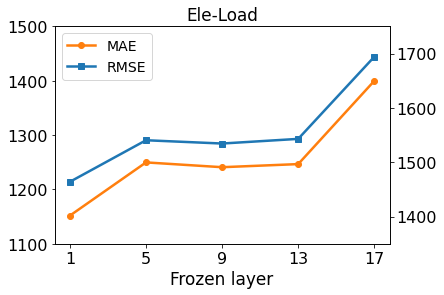

In [142]:
data = {
    # Load
    'MAE': [1151.86, 1249.73, 1240.91, 1246.62, 1399.69],
    'RMSE': [1464.07, 1540.49, 1534.45, 1543.01, 1694.04],
}


# Change the x_values as needed
x_values = [1, 5, 9, 13, 17]    # This is the current setting
new_x_values = [0, 1, 2, 3, 4]  # New x-values as an example

FONTSIZE=16

# Create figure and axis objects with a shared x-axis
fig, ax1 = plt.subplots()

# Load
y1_limits = (1100, 1500)
y2_limits = (1350, 1750)


ax1.set_ylim(y1_limits)
ax1.set_xlabel('Frozen layer', fontsize=FONTSIZE+1)
ax1.set_title('Ele-Load')
line1, = ax1.plot(new_x_values, data['MAE'], color='tab:orange', marker='o', linewidth=2.5, label='MAE')
ax1.tick_params(axis='y', labelsize=FONTSIZE,)

# Create y2-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylim(y2_limits)
line2, = ax2.plot(new_x_values, data['RMSE'], color='tab:blue', marker='s', linewidth=2.5, label='RMSE')  # Use new_x_values here
ax2.tick_params(axis='y', labelsize=FONTSIZE)


# Update x-ticks 
ax1.set_xticks(new_x_values)
ax1.set_xticklabels(['1', '5', '9', '13', '17'], fontsize=FONTSIZE) 


# Add legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.savefig('load_tune.jpg', bbox_inches='tight')
plt.show()

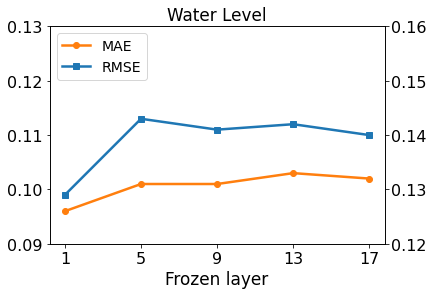

In [141]:
data = {   
    # Water
    'MAE': [0.096, 0.101, 0.101, 0.103, 0.102],
    'RMSE': [0.129, 0.143, 0.141, 0.142, 0.140]
}


# Change the x_values as needed
x_values = [1, 5, 9, 13, 17]    # This is the current setting
new_x_values = [0, 1, 2, 3, 4]  # New x-values as an example

FONTSIZE=16

# Create figure and axis objects with a shared x-axis
fig, ax1 = plt.subplots()


# Water
y1_limits = (0.09, 0.13)
y2_limits = (0.12, 0.16)


ax1.set_ylim(y1_limits)
ax1.set_xlabel('Frozen layer', fontsize=FONTSIZE+1)
ax1.set_title('Water Level')
line1, = ax1.plot(new_x_values, data['MAE'], color='tab:orange', marker='o', linewidth=2.5, label='MAE')
ax1.tick_params(axis='y', labelsize=FONTSIZE,)

# Create y2-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylim(y2_limits)
line2, = ax2.plot(new_x_values, data['RMSE'], color='tab:blue', marker='s', linewidth=2.5, label='RMSE')  # Use new_x_values here
ax2.tick_params(axis='y', labelsize=FONTSIZE)


# Update x-ticks 
ax1.set_xticks(new_x_values)
ax1.set_xticklabels(['1', '5', '9', '13', '17'], fontsize=FONTSIZE) 


# Add legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.savefig('water_tune.jpg', bbox_inches='tight')

# Show the plot
plt.show()